In [72]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import random
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

# Environment Analysis: why Q learning doesn't work

## env = gym.make('FrozenLake-v0')

In [11]:
# reward is constant/didn't get better FAIL
# with a 4x4 map, there are 16 states (the position of the agent)

## env = gym.make('Taxi-v2') 

In [12]:
# works well, converges, minimizes negative reward SUCCESS
# what does discrete 500 mean? its like a box for representing states. 
# there are 500 states because its all there, with the help of encoding and decoding

# Environments

In [94]:
# env = CliffWalkingEnv()
# env = gym.make('FrozenLake-v0') #now kinda works SUCCESS
env = gym.make('Blackjack-v0') #does not converge FAIL
# env = gym.make('Roulette-v0') #does not converge FAIL
# env = gym.make('NChain-v0') #does not coverge, fails to maximize reward FAIL
# env = gym.make('GuessingGame-v0') #lacks certain attributes, error FAIL
# env = gym.make('HotterColder-v0') #lacks certain attributes, error FAIL
# env = gym.make('Copy-v0') #action space is not discrete n FAIL
# env = gym.make('Taxi-v2') #works well, converges, minimizes negative reward SUCCESS
print("Action:", env.action_space)
print("Observation:", env.observation_space)


Action: Discrete(2)
Observation: Tuple(Discrete(32), Discrete(11), Discrete(2))


In [24]:
env.observation_space.sample()
# from guessing game. random number 
env.action_space.sample()

1

# Epsilon Greedy Policy

## def make_epsilon_greedy_policy(Q, epsilon, nA):

In [14]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
#         get the exploratory probabilties episilon
        A = np.ones(nA, dtype=float) * epsilon / nA
    
#         get the highest action value based on your current state
        best_action = np.argmax(Q[observation])

#         if all the action values are equal, then the action must be chosen randomly
        if list(Q[observation]).count(Q[observation][0]) == len(Q[observation]):
            best_action = np.random.choice(len(Q[observation]))

#         adjust the highest action value to get the rest of the probabilties
        A[best_action] += (1.0 - epsilon)
#         return the action probabilities
        return A
    return policy_fn

In [26]:
alist = [0,2,1]
print(type(alist))
acount = alist.count(alist[0])
acount
np.random.choice(alist)
np.arange(len(alist))

<class 'list'>


array([0, 1, 2])

## A = np.ones(nA, dtype=float) * epsilon / nA

In [27]:
nA = 6
# epsilon means exploratory probabilties -> spread out
epsilon = 0.2
# A = array of probabilities
# A = puts probablities on each action
A = np.ones(nA, dtype=float) * epsilon / nA
# sum of A is epsilon
sum(A)
A

array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333])

### What is Q?

### defaultdict(lambda: np.zeros(env.action_space.n))

In [28]:
# Q = dictionary with factory of array of 0s
# if a new key is passed, it will be created with array 0s
N = defaultdict(lambda: np.zeros(env.action_space.n))
N[1] += 1
N[2] += 2
N[3]
N[4][1] += 1
N

defaultdict(<function __main__.<lambda>()>,
            {1: array([1., 1.]),
             2: array([2., 2.]),
             3: array([0., 0.]),
             4: array([0., 1.])})

### What is Observation?

In [34]:
# what is observation?
# state is the observation as seen in policy(state)
# state in taxi's case is a discrete number as its being represented in observation space, with encoding

In [32]:
# creates an array of zeros for actions -> probabilities?
a = lambda: np.zeros(env.action_space.n)
a()

array([0., 0.])

## best_action = np.argmax(Q[observation])

In [35]:
# best_action = given an observation / current state, gets the index of the highest value
# best_action = index of the highest action value
best_action = np.argmax(N[4])
best_action


1

In [33]:
# after running entire program 
# key = state/observation,
# values = action probabilities? array of 0s

# Q

### A[best_action] += (1.0 - epsilon)

In [36]:
# (1.0 - epsilon) = the rest of the probabilties, since sum(A) == epsilon
# the highest action q value will get the highest/remaining probability
A = np.ones(nA, dtype=float) * epsilon / nA
A[best_action] += (1.0 - epsilon)
# sum(A) = 1.0
sum(A) 
A

array([0.03333333, 0.83333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333])

# Log Printer

In [101]:
def logprinter(state, action, reward, next_state):
    print("Current State:", state)
    print("Action:", action)
    print("Reward:", reward)
    print("Next State:", next_state)
    print()

# Random Learning:

In [106]:
# Baseline: Epsilon is 0.99
def random_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.99):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    actioncount = defaultdict(int)
    rewardcount = defaultdict(int)
    statecount = defaultdict(int)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        state = env.reset()

        for t in itertools.count():
            action_probs = policy(state) #return the action probabilities
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            statecount[state] += 1
            actioncount[action] += 1
            rewardcount[reward] += 1
            if done:
                break
            
            state = next_state
    
#     print()
#     print("StateCount:", statecount)
#     print("ActionCount:", actioncount)
#     print("RewardCount:", rewardcount)
    totalreward = 0
    for key, value in rewardcount.items():
        totalreward += value      
    
    return Q, stats, totalreward

# Q-Learning Algorithm:

In [105]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.05):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    actioncount = defaultdict(int)
    rewardcount = defaultdict(int)
    statecount = defaultdict(int)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    
#     each episode lasts until the end
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
#         just counts starting from 0 with step 1
#         itertools is a generator that can be only run once
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state) #return the action probabilities
#             chooses an action, based on its action probabilties
#             arange() = generates list of number of each action, with the distribution of action probabilities
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            
            next_state, reward, done, _ = env.step(action)
#             this is the observation = state/next state

            # Update statistics
#             until you reach the end of the episode, sum up all the rewards and update the total time
            stats.episode_rewards[i_episode] += reward
            
            stats.episode_lengths[i_episode] = t
            
            # TD Update
#             np.argmax(Q[next_state])
#             Q is an array containing the action values
#             next state is an observation which is represented in the observation space as a discrete number
#             np.argmax is getting the index of the highest action on that state
            best_next_action = np.argmax(Q[next_state])    
#             q learning update = reward + discounted value of the next state
#             the value of the next state is 1.that state 2.the highest action value
#             td target is the more accurate value we want to update towards
            td_target = reward + discount_factor * Q[next_state][best_next_action]
#             td delta is the temporal difference
            td_delta = td_target - Q[state][action]
#             we want to adjust the current state value towards the td target 
#             by moving that way by a certain step (temporal difference, td_delta) by a certain learning rate (alpha)
            Q[state][action] += alpha * td_delta
            
            
            statecount[state] += 1
            actioncount[action] += 1
            rewardcount[reward] += 1
               
#             logprinter(state, action, reward, next_state)


#             for each step, update the q values, if done then episode finish. else, the next state is the current state
            if done:
                break
            
            state = next_state
    
#     print()
#     print("StateCount:", statecount)
#     print("ActionCount:", actioncount)
#     print("RewardCount:", rewardcount)
    totalreward = 0
    for key, value in rewardcount.items():
        totalreward += value
        
    
    return Q, stats, totalreward

# DYNA Q-Learning Algorithm:

In [104]:
def dyna_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.05):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))


    '''<DYNA'''
    '''Table Creation'''
#     Note: if there is an indention error then the '''comment''' is the problem
#     create a Transition table
#     {state :
#         action: 
#             next_state: [transition count, transition probabilties]}

    T = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: [0.000001, 0])))
#     create a Reward table
    R = defaultdict(lambda: defaultdict(int))
    '''DYNA>'''
    
    actioncount = defaultdict(int)
    rewardcount = defaultdict(int)
    statecount = defaultdict(int)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    
#     each episode lasts until the end
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
#         just counts starting from 0 with step 1
#         itertools is a generator that can be only run once
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state) #return the action probabilities
#             chooses an action, based on its action probabilties
#             arange() = generates list of number of each action, with the distribution of action probabilities
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
#             this is the observation = state/next state

            # Update statistics
#             until you reach the end of the episode, sum up all the rewards and update the total time
            stats.episode_rewards[i_episode] += reward
            
            stats.episode_lengths[i_episode] = t
            
            # TD Update
#             np.argmax(Q[next_state])
#             Q is an array containing the action values
#             next state is an observation which is represented in the observation space as a discrete number
#             np.argmax is getting the index of the highest action on that state
            best_next_action = np.argmax(Q[next_state])    
#             q learning update = reward + discounted value of the next state
#             the value of the next state is 1.that state 2.the highest action value
#             td target is the more accurate value we want to update towards
            td_target = reward + discount_factor * Q[next_state][best_next_action]
#             td delta is the temporal difference
            td_delta = td_target - Q[state][action]
#             we want to adjust the current state value towards the td target 
#             by moving that way by a certain step (temporal difference, td_delta) by a certain learning rate (alpha)
            Q[state][action] += alpha * td_delta
            
            
            '''<DYNA'''           
            '''Table Update'''
#             transition count update
            T[state][action][next_state][0] += 1
#             reward table update
            R[state][action] = (1-alpha)*R[state][action] + alpha*reward
#             transition probabilities update
            for s in T.keys():
                for a in T[s].keys():
                    totalcount = 0
                    for ns in T[s][a].keys():
                        #counting total count
                        totalcount += T[s][a][ns][0] 
                    for ns in T[s][a].keys():
                        #computing probabilties: that next state's count / total state action pair counts
                        T[s][a][ns][1] = T[s][a][ns][0]/totalcount
            for i in range(10):
                '''Hallucination'''                             
                
    #             random state taken from observation
                random_state = random.choice(list(T))
    #             random action from taken state
                random_action = random.choice(list(T[random_state].keys()))

    #             generating next state
                next_state_list = []
                next_state_transition_probabilties = []
                for ns in T[random_state][random_action].keys():
                    next_state_list.append(ns)
                    next_state_transition_probabilties.append(T[random_state][random_action][ns][1])
                next_state_index = np.random.choice(range(len(next_state_list)), p=next_state_transition_probabilties) 
                generated_next_state = next_state_list[next_state_index]           
                generated_reward = R[random_state][random_action]

                '''Update Q-Table'''
                # TD Update
                best_next_action = np.argmax(Q[generated_next_state])    
                td_target = generated_reward + discount_factor * Q[generated_next_state][best_next_action]
                td_delta = td_target - Q[random_state][random_action]
                Q[random_state][random_action] += alpha * td_delta            

            '''DYNA>'''


            statecount[state] += 1
            actioncount[action] += 1
            rewardcount[reward] += 1
#             logprinter(state, action, reward, next_state)

#             for each step, update the q values, if done then episode finish. else, the next state is the current state
            if done:
                break
            
            state = next_state
    
#     print()
#     print("StateCount:", statecount)
#     print("ActionCount:", actioncount)
#     print("RewardCount:", rewardcount)
    totalreward = 0
    for key, value in rewardcount.items():
        totalreward += value
        
    
    return Q, stats, totalreward

# Test

## Random Policy Test

In [118]:
R, rstats, rreward = random_learning(env, 500)

Episode 500/500.

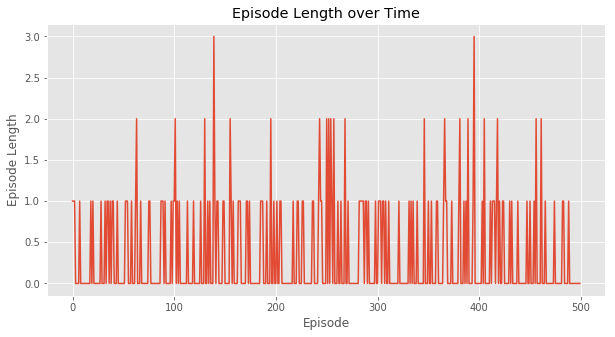

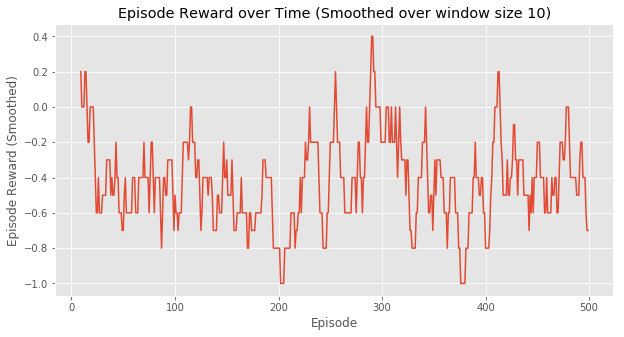

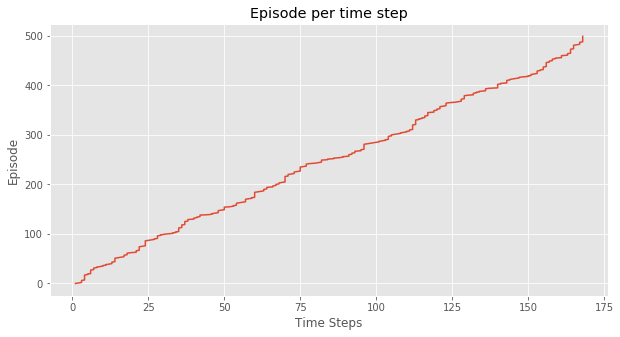

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [119]:
plotting.plot_episode_stats(rstats)

## Q-Learning Test

In [120]:
Q, qstats, qreward = q_learning(env, 500)

Episode 500/500.

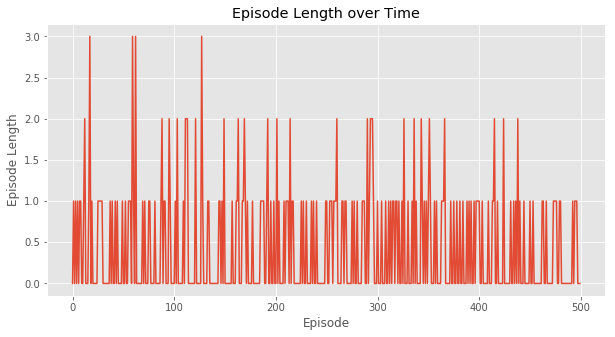

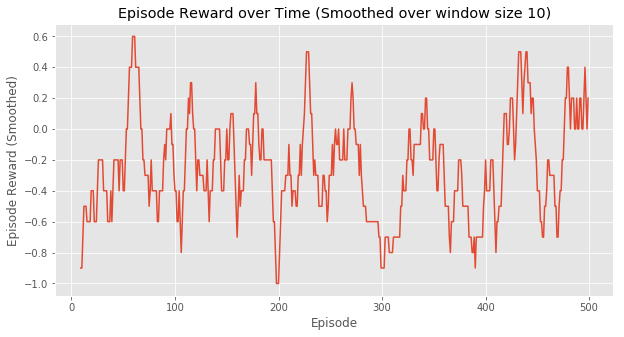

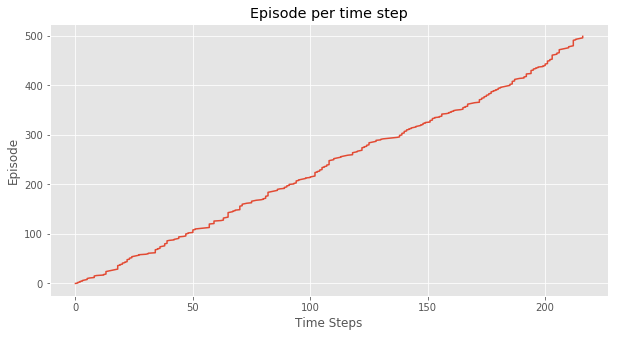

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [121]:
plotting.plot_episode_stats(qstats)

## Dyna Q Learning Test

In [122]:
dynaQ, dynaqstats, dynaqreward = dyna_q_learning(env, 500)

Episode 500/500.

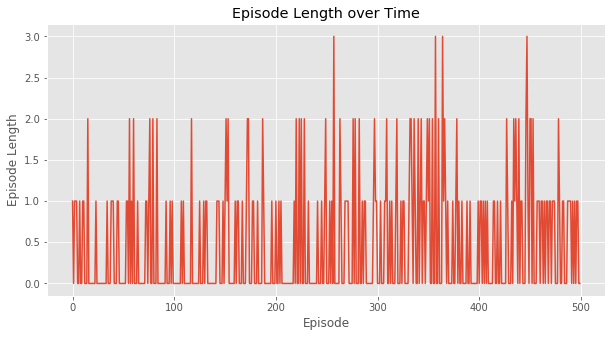

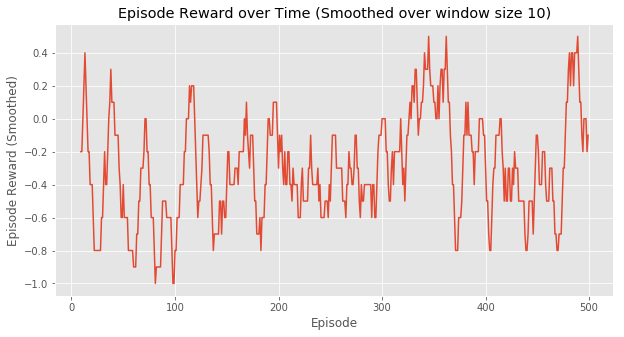

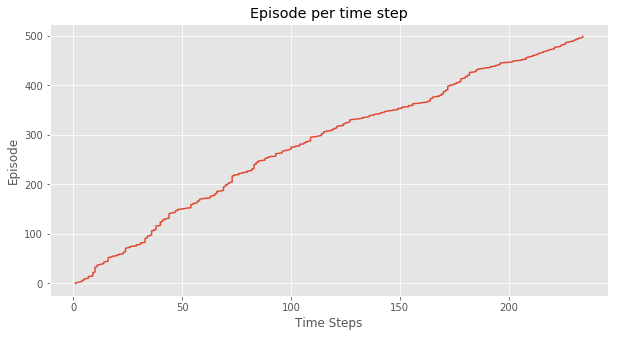

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [123]:
plotting.plot_episode_stats(dynaqstats)

In [142]:
R, rstats, rreward = random_learning(env, 1000)
Q, qstats, qreward = q_learning(env, 1000)
dynaQ, dynaqstats, dynaqreward = dyna_q_learning(env, 1000)

print('Total Rewards')
print('Random Policy:\t', rreward)
print('Q-Learning:\t', qreward)
print('Dyna Learning:\t', dynaqreward)

Episode 1000/1000.Total Rewards
Random Policy:	 1376
Q-Learning:	 1452
Dyna Learning:	 1460
